118.30224144788761


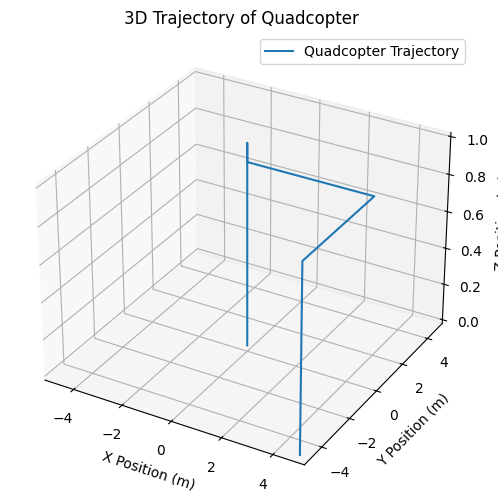

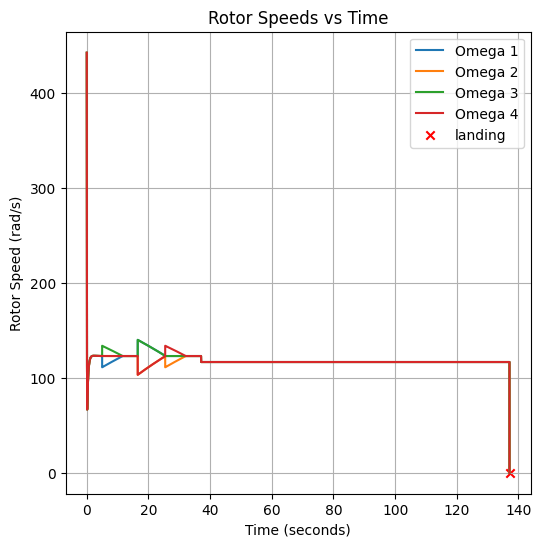

In [16]:
import numpy as np
import matplotlib.pyplot as plt

# Constants
k = 4.50e-5  # Lc
b = 5.02e-7  # Yawing
l = 0.2
m = 0.27777
g = 9.81
dt = 0.01

# PID Controller parameters
Kp = 35 #proportional
Ki = 30   # integral
Kd = 10  # derivative
setpoint = 1 # init height

# Initial conditions
height = 0
velocity = 0
integral_err = 0
prev_err = setpoint - height

# Trajectory and rotor speed data
tx, ty, tz = [], [], []
w1v, w2v, w3v, w4v = [], [], [], []
time_steps = []


rotor_diameter = 0.75  # Rotor diameter in meters
radius = rotor_diameter / 2
rho = 1.225  # Air density (kg/m^3)
A = np.pi * radius**2  # Rotor disc area (m^2)



def update(x, y, z, rotorspeed, time):
    tx.append(x)
    ty.append(y)
    tz.append(z)
    w1v.append(rotorspeed[0])
    w2v.append(rotorspeed[1])
    w3v.append(rotorspeed[2])
    w4v.append(rotorspeed[3])
    time_steps.append(time)

# 1. Vertical ascent using PID Controller
time = [0]
heights = [height]
omegas = []

for t in np.arange(dt, 5, dt):  # Simulate for 5 seconds
    err = setpoint - height
    integral_err += err * dt
    derivative_err = (err - prev_err) / dt

    # PID controller output for net thrust
    net_thrust = Kp * err + Ki * integral_err + Kd * derivative_err

    # Calculate total thrust
    thrust_per_rotor = net_thrust / 4
    if thrust_per_rotor < 0:
        thrust_per_rotor = 0  # no negative thrust
    omega = np.sqrt(thrust_per_rotor / k)


    # Calculate acceleration
    total_thrust = 4 * k * omega**2
    acceleration = (total_thrust / m) - g

    # Update state
    velocity += acceleration * dt
    height += velocity * dt

    # Store results
    time.append(t)
    heights.append(height)
    omegas.append(omega)

    prev_err = err


    # Update trajectory data
    update(0, 0, height, [omega, omega, omega, omega], t)

# 2. Horizontal motion
def computerotor(thrust, roll, pitch, yaw):
    omega_1_squared = (thrust / (4 * k)) - (pitch / (2 * l * k)) - (yaw / (4 * b))
    omega_2_squared = (thrust / (4 * k)) + (roll / (2 * l * k)) + (yaw / (4 * b))
    omega_3_squared = (thrust / (4 * k)) + (pitch / (2 * l * k)) - (yaw / (4 * b))
    omega_4_squared = (thrust / (4 * k)) - (roll / (2 * l * k)) + (yaw / (4 * b))

    return [
        np.sqrt(max(omega_1_squared, 0)),
        np.sqrt(max(omega_2_squared, 0)),
        np.sqrt(max(omega_3_squared, 0)),
        np.sqrt(max(omega_4_squared, 0))
    ]

def distance(pos1, pos2):
    return np.sqrt((pos1[0] - pos2[0])**2 + (pos1[1] - pos2[1])**2 + (pos1[2] - pos2[2])**2)

cpos = [0, 0, 1]  # Start at 1m height after ascent
tpos = [5, 0, 1]
while distance(cpos, tpos) > 0.1:
    thrust = m * g
    pitch = (tpos[0] - cpos[0]) * 0.01
    rotorspeed = computerotor(thrust, 0, pitch, 0)
    update(cpos[0], cpos[1], cpos[2], rotorspeed, time[-1])
    cpos[0] += 0.75 * dt  # Simulated horizontal movement
    time.append(time[-1] + dt)

# 3. Hover
for _ in range(int(5.0 / dt)):
    thrust = m * g
    rotorspeed = computerotor(thrust, 0, 0, 0)
    update(cpos[0], cpos[1], cpos[2], rotorspeed, time[-1])
    time.append(time[-1] + dt)

# 4. Yaw 90 degrees to the left
target_yaw = -90
current_yaw = 0
while abs(current_yaw - target_yaw) > 1:
    thrust = m * g
    yaw = (target_yaw - current_yaw) * 0.0001
    rotorspeed = computerotor(thrust, 0, 0, yaw)
    update(cpos[0], cpos[1], cpos[2], rotorspeed, time[-1])
    current_yaw -= 10 * dt  # Simulated yaw change
    time.append(time[-1] + dt)

# 5. Second horizontal motion
tpos = [5, -5, 1]
while distance(cpos, tpos) > 0.1:
    thrust = m * g
    roll = (tpos[1] - cpos[1]) * 0.01
    rotorspeed = computerotor(thrust, roll, 0, 0)
    update(cpos[0], cpos[1], cpos[2], rotorspeed, time[-1])
    cpos[1] -= 0.75 * dt  # Simulated horizontal movement
    time.append(time[-1] + dt)

# 6. Hover
for _ in range(int(5.0 / dt)):
    thrust = m * g
    rotorspeed = computerotor(thrust, 0, 0, 0)
    update(cpos[0], cpos[1], cpos[2], rotorspeed, time[-1])
    time.append(time[-1] + dt)

# 7. Vertical descent
target_altitude = 0.0
while cpos[2] > target_altitude:
    thrust = m * g * 0.9  # Slightly reduced thrust for descent
    rotorspeed = computerotor(thrust, 0, 0, 0)
    update(cpos[0], cpos[1], cpos[2], rotorspeed, time[-1])
    cpos[2] -= 0.01 * dt  # Simulated descent speed
    time.append(time[-1] + dt)

timepoints = 0
while cpos[2] < target_altitude and timepoints < 1:
    thrust = 0  # Slightly reduced thrust for descent
    rotorspeed = [0,0,0,0]
    update(cpos[0], cpos[1], cpos[2], rotorspeed, time[-1])
    time.append(time[-1] + dt)
    timepoints = timepoints + 1



# Plot the 3D trajectory
ax1 = plt.figure(figsize=(15, 6))

# 3D Trajectory Plot
f1 = ax1.add_subplot(121, projection='3d')
f1.plot(tx, ty, tz, label="Quadcopter Trajectory")
f1.set_xlabel("X Position (m)")
f1.set_ylabel("Y Position (m)")
f1.set_zlabel("Z Position (m)")
f1.set_xlim(-5,5)
f1.set_ylim(-5,5)
f1.set_zlim(0,1)
f1.set_title("3D Trajectory of Quadcopter")
f1.legend()

# Rotor Speeds Plot
plt.figure(figsize=(6, 6))
plt.plot(time_steps, w1v, label='Omega 1')
plt.plot(time_steps, w2v, label='Omega 2')
plt.plot(time_steps, w3v, label='Omega 3')
plt.plot(time_steps, w4v, label='Omega 4')
plt.xlabel('Time (seconds)')
plt.ylabel('Rotor Speed (rad/s)')
plt.title('Rotor Speeds vs Time')
plt.scatter(time[-1], rotorspeed[0],label  = "landing",marker = "x", color = 'red')
plt.legend()
plt.grid()

print((1/4)*(np.average(w1v)+np.average(w2v)+np.average(w3v)+np.average(w4v)))

